### 07_LSTM_stock_predict


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models,optimizers,Sequential,metrics,losses,utils
#from sklearn import preprocessing
import sys,os
print(tf.__version__)
print(sys.version)

2.0.0
3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]


In [4]:
stock = pd.read_csv('GOOG_Stock_Price_Train.csv')
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,324.360352,331.916199,324.077179,330.555054,330.555054,7400800
1,2012-01-04,330.366272,332.959412,328.175537,331.980774,331.980774,5765200
2,2012-01-05,328.925659,329.839722,325.994720,327.375732,327.375732,6608400
3,2012-01-06,327.445282,327.867523,322.795532,322.909790,322.909790,5420700
4,2012-01-09,321.161163,321.409546,308.607819,309.218842,309.218842,11720900


In [13]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

stock = stock.dropna()
stock['y'] = stock['Adj Close'].shift(-1) # 隔一天的股價
stock.iloc[:,1:3] = normalize(stock.iloc[:,1:3])
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,y
0,2012-01-03,0.085452,0.096001,324.077179,330.555054,330.555054,7400800,331.980774
1,2012-01-04,0.096609,0.097947,328.175537,331.980774,331.980774,5765200,327.375732
2,2012-01-05,0.093933,0.092129,325.994720,327.375732,327.375732,6608400,322.909790
3,2012-01-06,0.091183,0.088451,322.795532,322.909790,322.909790,5420700,309.218842
4,2012-01-09,0.079510,0.076408,308.607819,309.218842,309.218842,11720900,309.556641


In [20]:
stock['Date'] = pd.to_datetime(stock['Date'], format='%Y-%m-%d')
stock['weekday'] = stock['Date'].apply(lambda x: x.day)
stock['year'] = stock['Date'].apply(lambda x: x.year)
stock['Month'] = stock['Date'].apply(lambda x: x.month)
test = stock[-30:]
stock = stock[(stock['year']==2014)|((stock['year']==2015)&(stock['Month']<=3))|((stock['year']==2015)&(stock['Month']==4)&(stock['weekday']<=27))]
#stock & test
stock = stock.reset_index()
test = test.reset_index()
stock = stock.dropna()

In [22]:
test.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,y,weekday,year,Month
0,1227,2016-11-16,0.885793,0.906162,750.510010,764.479980,764.479980,1465200,771.229980,16,2016,11
1,1228,2016-11-17,0.907564,0.917985,764.229980,771.229980,771.229980,1304000,760.539978,17,2016,11
2,1229,2016-11-18,0.915831,0.922274,760.000000,760.539978,760.539978,1547100,769.200012,18,2016,11
3,1230,2016-11-21,0.899558,0.912391,760.599976,769.200012,769.200012,1330600,768.270020,21,2016,11
4,1231,2016-11-22,0.918171,0.925929,767.000000,768.270020,768.270020,1593100,760.989990,22,2016,11


In [23]:
stock.drop(["index",'Date','Open','High','Low',"Adj Close",'weekday','year','Month'], axis=1, inplace=True)
test.drop(['index','Date','Open','High','Low',"Adj Close",'weekday','year','Month'], axis=1, inplace=True)
stock.head()

,Close,Volume,y
0,552.963501,3666400,548.929749
1,548.929749,3355000,555.049927
2,555.049927,3561600,565.750366
3,565.750366,5138400,566.927673
4,566.927673,4514100,561.468201


In [24]:
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day+1):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)

X_train, Y_train = train_windows(stock, 5, 1)
X_test, Y_test = train_windows(test, 5, 1)

In [27]:
class stock_lstm(models.Model):
    def __init__(self,units):
        super(stock_lstm, self).__init__()
        self.rnn = Sequential([
          layers.SimpleRNN(units,input_shape=(5,2),dropout=0.2,return_sequences=True,unroll=True),
          layers.SimpleRNN(units,dropout=0.2,unroll=True)
        ])
        self.fc = layers.Dense(32)
        self.out = layers.Dense(1)

    def call(self, inputs, training=None):
        x = self.rnn(inputs)
        x = self.fc(x)
        out = self.out(x)
        return out

In [42]:
batchsz = 16
data = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
data = data.batch(batchsz,drop_remainder=True)

data_test = tf.data.Dataset.from_tensor_slices((X_test,Y_test))
data_test = data_test.batch(batchsz,drop_remainder=True)

units = 64
epochs = 13

rnn_model = stock_lstm(units)
rnn_model.compile(optimizer=optimizers.Adam(),loss="mean_absolute_error",metrics=['mean_absolute_error'])
rnn_model.fit(data,epochs=epochs, validation_data = data_test,shuffle=True,verbose=2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/13
20/20 - 1s - loss: 548.0705 - mean_absolute_error: 548.0706 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00
Epoch 2/13
20/20 - 0s - loss: 537.4450 - mean_absolute_error: 536.2594 - val_loss: 749.8290 - val_mean_absolute_error: 749.8290
Epoch 3/13
20/20 - 0s - loss: 522.7293 - mean_absolute_error: 521.4733 - val_loss: 733.4949 - val_mean_absolute_error: 733.4949
Epoch 4/13
20/20 - 0s - loss: 504.2961 - mean_absolute_error: 502.9535 - val_loss: 713.3860 - val_mean_absolute_error: 7

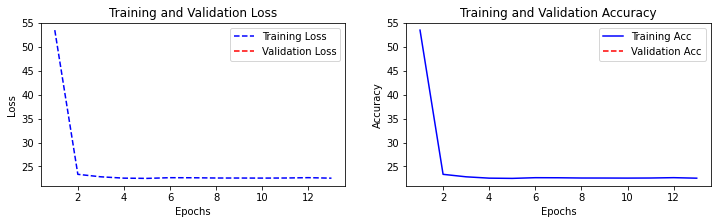

In [43]:
def visual_train_status(history):
        plt.figure(figsize=(12,3))
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(loss)+1)  
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, "b--", label="Training Loss")
        plt.plot(epochs, val_loss, "r--", label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # 顯示訓練和驗證準確度
        acc = history.history["mean_absolute_error"]
        val_acc = history.history["val_mean_absolute_error"]
        epochs = range(1, len(acc)+1)
        plt.subplot(1,2,2)
        plt.plot(epochs, acc, "b-", label="Training Acc")
        plt.plot(epochs, val_acc, "r--", label="Validation Acc")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
visual_train_status(history)